In [1]:
import numpy as np
import control as ctrl
import matplotlib.pyplot as plt
import mpc

Define continuous-time dynamics

In [2]:
Ac = np.array([[-1.2822,0,0.98, 0],[0,0,1,0],[-5.4293,0,-1.8366,0],[-128.2, 128.2, 0,0]])
Bc = np.array([[-0.3],[0],[-17],[0]])
Cc = np.array([[0,1,0,0],[0,0,0,1]])
Dc = np.array([[0],[0]])
sysc= ctrl.ss(Ac,Bc,Cc,Dc)

Sample system to obtain discrete-time representation

In [4]:
h = 0.25
sysd = ctrl.c2d(sysc,h)
[A,B,C,D] = ctrl.ssdata(sysd)

Define MPC controller

In [8]:
Q = np.eye(4); 
R = np.array([[10]]);
ulim = np.array([[0.262]]); 
ylim = np.array([[0.349],[1000]]); 
mpcProblemData={}
mpcProblemData['A'] = A; 
mpcProblemData['B']=B; 
mpcProblemData['C']=C; 
mpcProblemData['T'] = 10;
mpcProblemData['Q'] = Q;
mpcProblemData['R'] = R; 
mpcProblemData['QT'] = np.zeros((4,4));
mpcProblemData['ulim'] = ulim; 
mpcProblemData['ylim'] = ylim;
mpcProblemData['MT'] = np.zeros((4,4)); 
mpcProblemData['mT'] = np.zeros((4,1))

Now, perform simulation from initial value

In [5]:
x0 = np.array([[0],[0],[0],[10]])
Tsim = 5;                           # second
Nsim = int(Tsim/h)                  # Number of simulation step
x = x0; 
xLogg = np.empty((4,Nsim+1)); 
xLogg[:,[0]] = x0; 
uLogg = np.empty((1,Nsim));
for t in range(Nsim):
    u = mpc.mpcController(mpcProblemData,x)
    x = A@x+B@u
    uLogg[:,[t]] = u; 
    xLogg[:,[t+1]] = x;


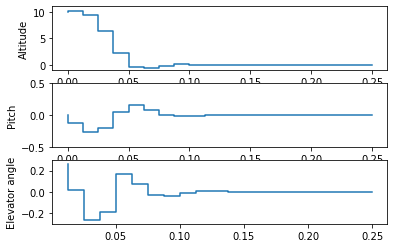

In [6]:
time = np.linspace(0,h,Nsim+1);
plt.subplot(311)
plt.step(time,xLogg[3,:]); 
plt.ylabel('Altitude'); plt.ylim((-1,11))
plt.subplot(312)
plt.step(time,xLogg[1,:]); 
plt.ylabel('Pitch'); plt.ylim((-0.5,0.5))
plt.subplot(313)
plt.step(time[1:Nsim+1],uLogg[0,:]); plt.ylabel('Elevator angle'); plt.ylim((-0.3,0.3));

Now, modify problem to account for input rate constraints

In [7]:
Ae = np.block([[A,B],[np.zeros((1,4)), np.eye(1)]]);
Be = np.block([[B],[np.eye(1)]])
Ce = np.block([[C, np.zeros((2,1))],[np.zeros((1,4)), np.eye(1)]])
Qe = np.block([ [Q, np.zeros((4,1))], [np.zeros((1,4)), R]]); Re=np.array([[0.01]])
ylime = np.block([[ylim],[ulim]]); ulime=np.array([[0.524*h]]);

In [8]:
mpcProblemData={}
mpcProblemData['A']=Ae; mpcProblemData['B']=Be; mpcProblemData['C']=Ce; mpcProblemData['T']=10;
mpcProblemData['Q']=Qe;mpcProblemData['R']=Re; mpcProblemData['QT']=np.zeros((5,5));
mpcProblemData['ulim']=ulime; mpcProblemData['ylim']=ylime;
mpcProblemData['MT']=np.zeros((5,5)); mpcProblemData['mT']=np.zeros((5,1))

In [9]:
x0=np.array([[0],[0],[0],[10],[0]])
x=x0; 
xLogg=np.empty((5,Nsim+1)); xLogg[:,[0]]=x0; duLogg=np.empty((1,Nsim));
for t in range(Nsim):
    du=mpc.mpcController(mpcProblemData,x)
    x=Ae@x+Be@du
    duLogg[:,[t]]=du; xLogg[:,[t+1]]=x;

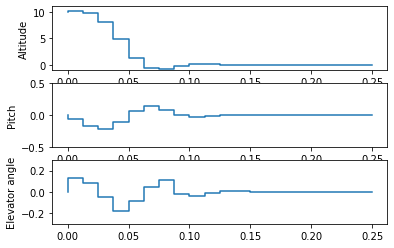

In [10]:
#plt.step(np.linspace(0,h,Tsim),uLogg[0,:])
plt.subplot(311)
plt.step(time,xLogg[3,:]); 
plt.ylabel('Altitude'); plt.ylim((-1,11))
plt.subplot(312)
plt.step(time,xLogg[1,:]); 
plt.ylabel('Pitch'); plt.ylim((-0.5,0.5))
plt.subplot(313)
plt.step(time,xLogg[4,:]); plt.ylabel('Elevator angle'); plt.ylim((-0.3,0.3));

Finally, set prediction horizon to T=4

In [11]:
mpcProblemData['T'] = 4;
x0 = np.array([[0],[0],[0],[10],[0]])
x = x0; 
xLogg = np.empty((5,Nsim+1)); 
xLogg[:,[0]] = x0; 
duLogg = np.empty((1,Nsim));
for t in range(Nsim):
    du=mpc.mpcController(mpcProblemData,x)
    x=Ae@x+Be@du
    duLogg[:,[t]]=du; xLogg[:,[t+1]]=x;

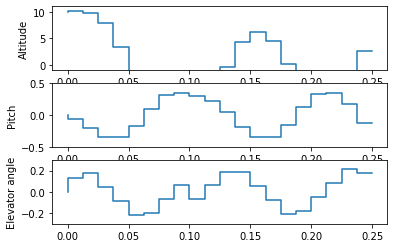

In [12]:
#plt.step(np.linspace(0,h,Tsim),uLogg[0,:])
plt.subplot(311)
plt.step(time,xLogg[3,:]); 
plt.ylabel('Altitude'); plt.ylim((-1,11))
plt.subplot(312)
plt.step(time,xLogg[1,:]); 
plt.ylabel('Pitch'); plt.ylim((-0.5,0.5))
plt.subplot(313)
plt.step(time,xLogg[4,:]); plt.ylabel('Elevator angle'); plt.ylim((-0.3,0.3));

Now, add terminal penalty based on receding-horizon LQR proof.

In [13]:
(K,Pe,E)=ctrl.dlqr(Ae,Be,Qe,Re)
mpcProblemData['QT']=Pe

In [14]:
mpcProblemData['T'] = 4;
x0 = np.array([[0],[0],[0],[10],[0]])
x = x0; 
xLogg = np.empty((5,Nsim+1)); 
xLogg[:,[0]] = x0; 
duLogg=np.empty((1,Nsim));
for t in range(Nsim):
    du=mpc.mpcController(mpcProblemData,x)
    x=Ae@x+Be@du
    duLogg[:,[t]]=du; xLogg[:,[t+1]]=x;

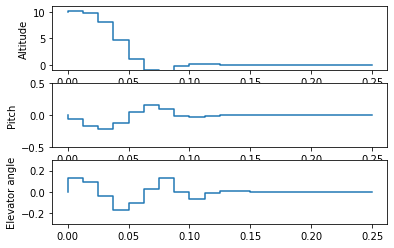

In [15]:
#plt.step(np.linspace(0,h,Tsim),uLogg[0,:])
plt.subplot(311)
plt.step(time,xLogg[3,:]); 
plt.ylabel('Altitude'); plt.ylim((-1,11))
plt.subplot(312)
plt.step(time,xLogg[1,:]); 
plt.ylabel('Pitch'); plt.ylim((-0.5,0.5))
plt.subplot(313)
plt.step(time,xLogg[4,:]); plt.ylabel('Elevator angle'); plt.ylim((-0.3,0.3));